
# 📌 **Projec: Temperature Forecasting with LSTM**

## **1️⃣ Required Libraries**
Below is a list of essential Python libraries used in this notebook, along with their purposes:

- **NumPy**: Numerical computations and array manipulations.
- **Pandas**: Handling and processing time-series data.
- **Matplotlib & Seaborn**: Data visualization.
- **TensorFlow/Keras**: Building and training the LSTM model.
- **Scikit-learn**: Data preprocessing and evaluation metrics.
- **Geopandas**: Geospatial data visualization (if applicable).

## **2️⃣ Notebook Sections**
1. **Data Loading & Preprocessing** - Reading climate data, handling missing values.
2. **Exploratory Data Analysis (EDA)** - Visualizing trends, seasonal variations.
3. **Feature Engineering** - Selecting key variables, creating time-series sequences.
4. **Model Building** - Implementing LSTM architecture.
5. **Model Training & Evaluation** - Training the LSTM model and analyzing performance.
6. **Forecasting & Visualization** - Generating future temperature predictions.
7. **Conclusion & Future Improvements** - Discussing results and next steps.

---

Let's begin! 🚀


## Predicting Temperature and Precipitation and Analyzing Their Relationship in Germany


#### Datase 1940-2024

1. Search, download and view data
https://cds.climate.copernicus.eu/datasets/sis-ecde-climate-indicators?tab=overview



- Load the dataset and convert to DataFrame
- Filter for German regions (NUTS codes starting with "DE")
- Convert temperatures from Kelvin to Celsius
- Filter out invalid temperatures

In [37]:
### 🔹 Code Section 1: [Short Description Here]
### Purpose of this cell:
# This code is used for ... It processes the data and extracts key features.
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset and convert to DataFrame
temp_data = xr.open_dataset("data/01_mean_temperature-reanalysis-monthly-layer-nuts_1-latitude-1940-2023-v1.0.nc")
temperature = temp_data["t2m"]
temperature_df = temperature.to_dataframe().reset_index()

# Filter for German regions (NUTS codes starting with "DE")
german_regions = temperature_df[temperature_df["nuts"].str.startswith("DE")]

# Convert temperatures from Kelvin to Celsius
german_regions["t2m"] = german_regions["t2m"] - 273.15

# Visualize temperature data
plt.figure(figsize=(12, 6))
plt.scatter(german_regions["time"], german_regions["t2m"], alpha=0.5, label="Temperature Data")
plt.axhline(y=-50, color='red', linestyle='--', label="Min Threshold (-50°C)")
plt.axhline(y=50, color='red', linestyle='--', label="Max Threshold (50°C)")
plt.title("Scatter Plot of Temperatures in Germany (°C)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.show()

# Filter out invalid temperatures (e.g., outside a reasonable range)
temperature_df = german_regions[
    (german_regions["t2m"] >= -50) & (german_regions["t2m"] <= 50)
]

# Inspect the cleaned data
print("Before Cleaning:", german_regions.shape)
print("After Cleaning:", temperature_df.shape)
print(temperature_df.head())




### Plot for each German region

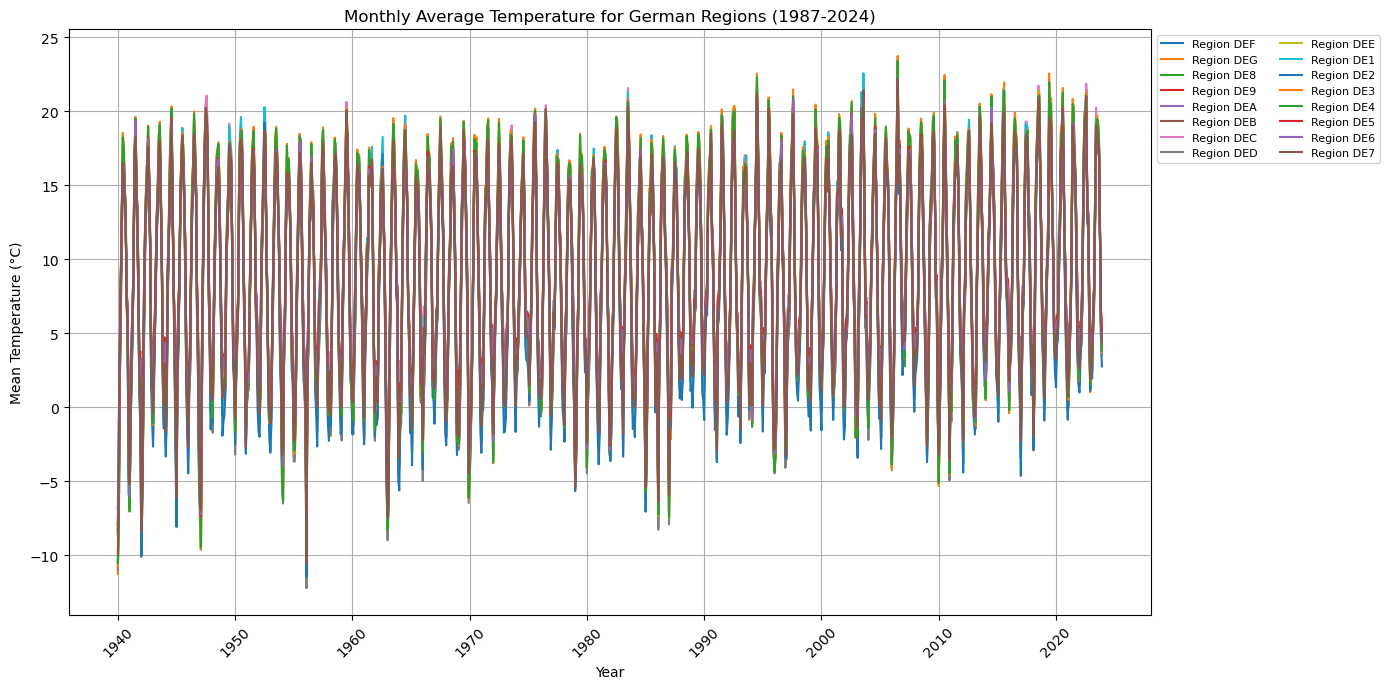

In [38]:
### 🔹 Code Section 2: [Short Description Here]
### Purpose of this cell:
# This code is used for ... It processes the data and extracts key features.
import matplotlib.pyplot as plt
import pandas as pd

# Plot for each German region
regions = german_regions["nuts"].unique()
plt.figure(figsize=(14, 7))

for region in regions:
    region_data = german_regions[german_regions["nuts"] == region]
    plt.plot(
        region_data["time"],
        region_data["t2m"],
        label=f"Region {region}"
    )

# Customize the plot
plt.title("Monthly Average Temperature for German Regions (1987-2024)")
plt.xlabel("Year")
plt.ylabel("Mean Temperature (°C)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8, ncol=2)  # Move and compact legend
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.tight_layout()
plt.show()


## Steps for LSTM Modeling for a specific region (e.g., Region DE1)

Prepare Data:

- Normalize the temperature data using MinMaxScaler.
- Create sequences and labels using a sliding window approach to structure data for time series forecasting.

Split Data:

- Divide the dataset into training and testing sets to evaluate the model's performance.

Build the LSTM Model:

- Define an LSTM model with layers for sequence processing and prediction.
- Compile the model using the Adam optimizer and Mean Squared Error loss.

Train the Model:

- Fit the model on the training set and validate it on the testing set.

Evaluate and Predict:

- Evaluate the model's performance on the test set.
- Predict future values and inverse-transform the scaled data for interpretation.

Visualize Results:

- Compare predicted values with actual values to assess the model's accuracy.

## Nuts = DEA

In [ ]:
### 🔹 Code Section 3: [Short Description Here]
### Purpose of this cell:
# This code is used for ... It processes the data and extracts key features.
import numpy as np  
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume `temperature_df` contains your data with columns: ['nuts', 'time', 't2m']

# Step 1: Prepare data for all regions
regions = temperature_df["nuts"].unique()
all_X, all_y = [], []
scalers = {}

for region in regions:
    region_data = temperature_df[temperature_df["nuts"] == region]
    region_data = region_data.sort_values("time")
    temperatures = region_data["t2m"].values.reshape(-1, 1)
    
    # Normalize the data
    scaler = StandardScaler()
    temperatures_scaled = scaler.fit_transform(temperatures)
    scalers[region] = scaler  # Store scaler for each region
    
    # Create sequences
    seq_length = 72  # Use 72 months of data to predict the next month
    X, y = create_sequences(temperatures_scaled, seq_length)
    all_X.append(X)
    all_y.append(y)

# Combine all regions' data
X_combined = np.concatenate(all_X, axis=0)
y_combined = np.concatenate(all_y, axis=0)

# Step 4: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Step 5: Define the LSTM lstm_model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the lstm_model
history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Step 7: Predict future temperatures
predictions = lstm_model.predict(X_test)

# Step 8: Inverse transform the predictions to original scale
# Using the scaler of a representative region (assuming similar distributions)
region_sample = regions[0]
y_test_original = scalers[region_sample].inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scalers[region_sample].inverse_transform(predictions)

# Step 9: Evaluate the lstm_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Step 10: Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual Temperatures", color="blue")
plt.plot(y_pred_original, label="Predicted Temperatures", color="orange")
plt.title("Actual vs Predicted Temperatures")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


# LSTM Model Training for Multiple Regions

## Overview
This process involves training an LSTM model for predicting temperatures for multiple regions identified in the dataset. Each region is handled separately, and results are saved and visualized for comparison.

---

## Steps

### 1. Identifying Unique Regions
Using `temperature_df["nuts"].unique()`, all unique regions in the dataset are identified.

### 2. Looping Through Each Region
For each region, the following steps are executed in a loop:
- **Filter the data**: Extract temperature data for the specific region.
- **Normalize the data**: Scale the temperature values to a range suitable for the LSTM model.
- **Create sequences**: Generate sequences of past data to be used as input for the model.
- **Train the model**: Train the LSTM model using the prepared data.
- **Make predictions**: Predict future temperatures based on the trained model.

### 3. Saving and Displaying Results
The metrics (MAE, MSE, RMSE, and R²) for each region are calculated, saved, and displayed for evaluation.

### 4. Plotting Results for Each Region
For each region, a plot is generated showing the actual vs. predicted temperatures, enabling visual comparison of model performance.

---

## Output
- Metrics for each region are displayed in the console for easy comparison.
- Visual plots for actual vs. predicted temperatures are created for every region.


In [ ]:
### 🔹 Code Section 4: [Short Description Here]
### Purpose of this cell:
# This code is used for ... It processes the data and extracts key features.
import pandas as pd  
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm

# Step 1: Input the target month and year
target_year = int(input("Enter the target year (e.g., 2025): "))
target_month = int(input("Enter the target month (e.g., 7 for July): "))

# Step 2: Prepare predicted temperatures for all regions
regions = temperature_df["nuts"].unique()
predicted_data = []
scalers = {}

for region_code in regions:
    region_data = temperature_df[temperature_df["nuts"] == region_code].copy()
    region_data["time"] = pd.to_datetime(region_data["time"])

    # Get the last known date for the region
    last_known_date = region_data["time"].max()
    
    if len(region_data) < 72:  # Ensure sufficient data for training
        continue  # Skip regions with too few data points

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    temperatures = region_data["t2m"].values.reshape(-1, 1)
    temperatures_scaled = scaler.fit_transform(temperatures)
    scalers[region_code] = scaler  # Store scaler for each region

    if pd.Timestamp(target_year, target_month, 1) <= last_known_date:
        # Use actual data if the target date is in the past
        matching_row = region_data[
            (region_data["time"].dt.year == target_year) &
            (region_data["time"].dt.month == target_month)
        ]
        if not matching_row.empty:
            temperature = matching_row.iloc[0]["t2m"]
        else:
            temperature = np.nan
    else:
        # Predict future temperatures
        num_months_to_predict = (target_year - last_known_date.year) * 12 + (target_month - last_known_date.month)
        recent_data = temperatures_scaled[-72:].reshape(-1, 1)  # Use last 72 months
        recent_data_sequence = recent_data.reshape(1, 72, 1)

        for _ in range(num_months_to_predict):
            next_month_normalized = lstm_model.predict(recent_data_sequence)
            next_month_normalized = np.clip(next_month_normalized, 0, 1)  # Ensure values are within MinMax range
            next_month_temperature = scaler.inverse_transform(next_month_normalized).item()
            recent_data_sequence = np.roll(recent_data_sequence, -1, axis=1)
            recent_data_sequence[0, -1, 0] = next_month_normalized.item()

        temperature = next_month_temperature

    predicted_data.append({"region_code": region_code, "predicted_temperature": temperature})

predicted_data_df = pd.DataFrame(predicted_data)

# Step 3: Merge with GeoJSON
germany_map = gpd.read_file("data/2_hoch.geo.json")

# Map NUTS codes to region names if necessary
nuts_to_name_mapping = {
    "DE1": "Baden-Württemberg",
    "DE2": "Bayern",
    "DE3": "Berlin",
    "DE4": "Brandenburg",
    "DE5": "Bremen",
    "DE6": "Hamburg",
    "DE7": "Hessen",
    "DE8": "Mecklenburg-Vorpommern",
    "DE9": "Niedersachsen",
    "DEA": "Nordrhein-Westfalen",
    "DEB": "Rheinland-Pfalz",
    "DEC": "Saarland",
    "DED": "Sachsen",
    "DEE": "Sachsen-Anhalt",
    "DEF": "Schleswig-Holstein",
    "DEG": "Thüringen"
}

predicted_data_df["region_name"] = predicted_data_df["region_code"].map(nuts_to_name_mapping)

# Merge with GeoJSON
merged_geojson = germany_map.merge(predicted_data_df, left_on="name", right_on="region_name", how="left")

from matplotlib.colors import Normalize

# Set fixed min and max values
fixed_vmin = 13  # Minimum temperature for summer
fixed_vmax = 30  # Maximum expected temperature

# Normalize colormap with fixed range
norm = Normalize(vmin=fixed_vmin, vmax=fixed_vmax)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_geojson["temperature_display"] = merged_geojson["predicted_temperature"].fillna(merged_geojson["predicted_temperature"].mean())

merged_geojson.plot(
    column="temperature_display",
    cmap="Reds",
    legend=True,
    ax=ax,
    edgecolor="black",
    norm=norm  # Apply fixed normalization
)

ax.set_title(f"Temperatures for {target_month:02d}/{target_year}", fontsize=16)
ax.set_axis_off()

cbar = ax.get_figure().get_axes()[-1]
cbar.set_ylabel("Temperature (°C)", fontsize=12)

plt.show()